Devin Short 
30 June 2023 
shortda@uw.edu

This is a tutorial demonstrating how to explore data parsed out of the catalogues. The idea is to understand what kind of content we've generated, get a feel for how well our current tools are working, and try improving them. This notebook requires functions from `reporting.py`, currently living in the scripts directory of the github repository.

Let's import some packages and set parameters we'll use below.

In [25]:
#%pip install pandas
import pandas as pd
import re

pd.set_option('display.max_colwidth', 500)

# If you're running this notebook from a directory that doesn't contain
# reporting.py you'll either need to edit the following line to reflect
# the relative location of the reporting module or copy reporting.py
# into the current directory
from reporting import histogram_strings_by_length

# The year determines which issue of the catalogue we're looking at
# across the entire notebook
year = 21

## <u>Summarizing data with histograms</u>

One way to start is by looking at the number of characters in all entries parsed out of one year of the catalogue. Most good entries are going to have similar lengths because they display similar data. Extremely short entries are probably fragments created by OCR errors and some extremely long entries will be multiple entries the code we're using failed to split apart.

We can get an overview by creating a histogram of the entry lengths. A histogram shows a series of bins on the bottom axis and the number of objects falling into each bin on the vertical axis. In this case I've created bins 5 characters wide, so each bar in the plot below shows the number of entries 0-5 characters long, 5-10 characters long, etc.

I've also created parameters to examine "underflow" and "overflow" regions of the histogram. Underflow and overflow counts in a histogram refer to objects that are irrelevant for some reason. In many cases a histogram will have a single underflow or overflow bin that aggregates everything outside the region of interest, but I've included the full histogram here and shaded the outflow regions.

## <u>Testing new methods</u>

Some entries in the third peak reveal a flaw in our current approach to splitting the entries: some lines in the catalogue aren't part of an entry. These lines have the form `<author name> see <author name>`, suggesting a reader looking up one author might actually be looking for someone else. The code we're using assumes entries end with an OCR line ending in `12`. It doesn't handle the lines pointing from one author to another, so those lines usually get tacked onto the front of the following entry. The current code does sometimes parse these author-to-author lines as individual entries. It looks to me like this happens when they are the last OCR'd line on a page.

I figured that out by repeatedly looking at samples generated by the next cell and then searching the Hathi Trust online PDF for the contents of author-to-author lines that appeared separate from a full entry.

In [26]:
# ALL CODE IN THIS CELL IS ADAPTED FROM Parsing_ECB_1912_wi23.ipynb

# read the Hathi Trust OCR into memory
with open(f'../princeton_years/ecb_19{year}.txt', encoding='utf8') as f:
    ocr_full_text = f.read()

# Separate main text from the front matter of the catalogue (note the
# string called ocr_main_text still has the back matter attached until
# a later step)
# Note python allows multiple assignment: the split operation below
# creates a two-element list whose elements are then assigned to two
# different variables
ocr_front_matter, ocr_main_text = re.split(r'centimetres', ocr_full_text)

appendix_pattern = (
    r"Publication suspended"
)

# Separate main text from the back matter of the catalogue
ocr_main_text, ocr_back_matter = re.split(appendix_pattern, ocr_main_text)

# Make a regular expression to capture headers at the top of each
# catalogue page
header_capital_letters = r"^(?:[A-Z\-\'\sÈ]+)"
header_pattern = r"^#(?s:.*?){}(?s:.*?){}(?s:.*?){}$".format(
    header_capital_letters, header_capital_letters, header_capital_letters
)

# Split the main text into pages and strip the headers. According to
# Parsing_ECB_1912_wi23.ipynb this method fails to remove six headers.
pages = [
    re.sub(header_pattern, '', page, flags=re.M)
    for page in ocr_main_text.split('\f')
]

# Now find all lines ending in 12 and insert a token to split on
entries_by_page = [
    re.sub(r'(\W2I\.?$)', '\\1<ENTRY_CUT>', page, flags=re.M)
    for page in pages
]

# Split on the token to create a list of lists where each element is
# a list of entries on an individual page
entries_by_page = [
    re.split(r'<ENTRY_CUT>', page, flags=re.M)
    for page in entries_by_page
]

print(f'total entries: {sum([len(p) for p in entries_by_page])}')

total entries: 305


Now let's test a new regular expression for splitting entries 

In [27]:
# This cell assumes we're looking at the 1912 catalogue; try changing
# this code (and the year parameter in the first code cell of the
# notebook) to catch OCR mistakes for a different year.

# create a list of possible values the OCR software might have created
# when it ran into an 11 or 12 on the page
ocr_interpretations_of_21 = [
    '21',
    '2i',
    '2I',
    'z1',
    'Z1',
    'zi',
    'zI',
    'Zi',
    'ZI'
]
ocr_interpretations_of_22 = [
    'zz',
    '22',
    'ZZ',
    '2Z',
    'Z2',
    'z2',
    '2z'
]
terminators = ocr_interpretations_of_21 + ocr_interpretations_of_22

# modify the existing regex with our new options
entry_terminator_regex = r'(\W({})\.?$)'.format('|'.join(terminators))

# get a new set of entries the same way as above, but using the new
# regular expression
new_entries_by_page = [
    re.sub(entry_terminator_regex, '\\2<ENTRY_CUT>', page, flags=re.M)
    for page in pages
]
new_entries_by_page = [
    re.split(r'<ENTRY_CUT>', page, flags=re.M)
    for page in new_entries_by_page
]

print(f'total entries: {sum([len(p) for p in new_entries_by_page])}')


total entries: 305


OK, we might have found 157 entries that weren't caught with the previous splitting expression, meaning we might have gained 314 entries that were either not present or invalid in the previous data set. Let's see if that's really what happened.

number of new entries: 0


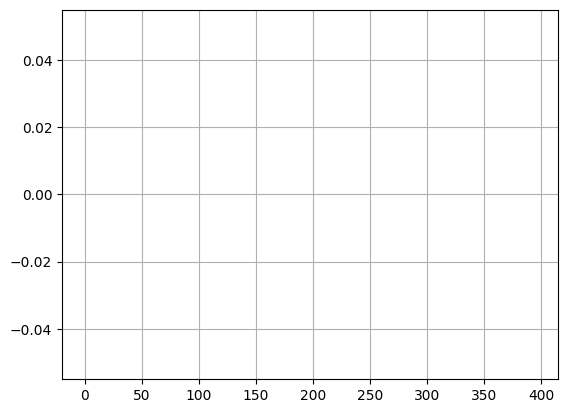

In [28]:
# It can be much more efficient to do things like check if elements in
# one sequence exist in another using pandas objects rather than the
# standard python library, so I flatten the lists of lists of entries
# into pandas series containing all the entries.
old_entries = pd.Series(
    [e for page in entries_by_page for e in page],
    dtype=pd.StringDtype()
)
new_entries = pd.Series(
    [e for page in new_entries_by_page for e in page],
    dtype=pd.StringDtype()
)

# strip nonprinting characters and replace all newlines in each entry
# with spaces
old_entries = old_entries.str.strip()
new_entries = new_entries.str.strip()
old_entries = old_entries.str.replace('\n', ' ')
new_entries = new_entries.str.replace('\n', ' ')

# Get new entries that don't exist in the old set
new_entries = new_entries.loc[~new_entries.isin(old_entries)]

print(f'number of new entries: {len(new_entries)}')

# plot a histogram of lengths of the new entries
fig2 = new_entries.map(len).hist(bins=range(0, 400, 5))

The histogram we started with covers nearly 20,000 entries. Here we have only 300, but the plot generated in the previous cell already looks extremely similar to the one at the top of the document. This means we can probably assume the entries we've produced here are just as good as the rest of the entries we're already capturing. Probably! I haven't actually looked at the new entries in detail, but it's 0200 and I need to finish this up.

## <u>Wrapping up</u>

The goal here was to demonstrate how to play around with the data and the code for our summer project. The general method I followed was something like the following:
1. Get some kind of overview of the output from our current parsing operations. I went with the size of the strings but there are all kinds of ways to do this. You could think about features of strings that have words in all caps and compare them to strings that don't have capitalized words (publishers in the author-first entries are almost always capitalized). You could start by exploring the dataframes, where the strings have been parsed out into specific fields, rather than thinking about whole entries. Explore the results we have and find something you think is interesting. If you can't think of a way to use that feature to explore the data, run it by one of your colleagues and see what they think. Your team is always your best asset!
2. Use that view of the data to characterize what's working and what isn't. In this case it was clear that unreasonably short or long strings were going to have some errors, so I was able to look at those entries to see where there might be problems in the existing process.
3. Find out which part of the existing code is relevant for the feature you're interested in. This part is probably going to be hard if you haven't had a much experience with programming. If it isn't obvious how to proceed after you've had a look at some of the scripts, ask me or Anna how to do what you want to do.
4. See if you can modify the code to get different results.
5. Use the same overview process you started with to compare your new result with the old one.
